# SIR model
A very basic model for the spread of a dissease is the Succeptible, Infected, Recovered (SIR) model. This model splits a population into three groups.

1. $S(t)$ - the part of the population that is succeptible but not yet infected with the disease
2. $I(t)$ - the part of the population that is infected with the disease
3. $R(t)$ - the part of the population that has recovered from the disease. 

The SIR model uses a system of ODE's to describe how these three groups change over time. In it's most simple form, the model uses only the contact ration $\beta$ and the mean recovery rate $\gamma$ for this.

Below is a python implementation of this simple model, taken from https://scipython.com/book/chapter-8-scipy/additional-examples/the-sir-epidemic-model/. 


In [5]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.integrate import odeint

# The SIR model differential equations.
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

def SIR_model(beta=0.2, gamma=0.1, I0=1, R0=0, 
              N=1000, t=np.linspace(0, 160, 160)):
    '''
    
    Parameters
    ----------
    beta : float
           contact rate
    gamma : float
            recovery rate
    I0 : int
         initial value infected
    R0 : int
         initial value recovered
    N : int
        population size
    t : ndarray
        points in time
    
    '''
    S0 = N - I0 - R0
    
    # Initial conditions vector
    y0 = S0, I0, R0
    # Integrate the SIR equations over the time grid, t.
    ret = odeint(deriv, y0, t, args=(N, beta, gamma))
    S, I, R = ret.T
    
    return {'S':S, 'I':I, 'R':R}


## Connecting the SIR model with the workbench

Let's connect this simple model to the workbench. We make the following assumptions
1. $\beta$ and $\gamma$ are uncertain. We assume that $\beta$ is somewhere between 0.05 and 0.3, while $\gamma$ is somewhere between 0.01, and 0.15.
2. The outcomes of interest are $S(t)$, $I(t)$, and $R(t)$ over time.

To connect the model to the workbench, we need to do at least 3 things:
1. **Instantiate a model class**; the workbench comes with a variety of model classes for making it easy to connect with existing simulation packages such as Vensim, PySD, Simio, or Netlogo. Since we have a model implemented in Python, we can use the most basic Model class.
2. **Specify the uncertain parameters** (and/or decision levers); Note below how the name of the parameters matched the name of the keyword arguments of the SIR_model function. The workbench makes a distinction between RealParameters, IntegerParameters, BinaryParameters, and CategoricalParameters. For this example, our parameters $\beta$ and $\gamma$ have a continuous range so we use RealParameters 
3. **Specify the outcomes of interest**; the workbench makes a distinction between TimeSeriesOutcomes and ScalarOutcomes. $S$, $I$, and $R$ are time series, so we use TimeSeriesOutcomes

In [8]:
pip install ipyparallel 

Note: you may need to restart the kernel to use updated packages.


In [9]:
from ema_workbench import Model, RealParameter, TimeSeriesOutcome

model = Model('SIR', function=SIR_model)

model.uncertainties = [RealParameter('beta', 0.05, 0.3),
                       RealParameter('gamma', 0.01, 0.15)]

model.outcomes = [TimeSeriesOutcome('S'),
                  TimeSeriesOutcome('I'),
                  TimeSeriesOutcome('R')]


The code above is a minimum working example of how to connect a model, the SIR_model function in this case, to the ema workbech. Even very large and complex cases will mimic this structure. 

# Running the model with the workbench

The next step is to run the model. For this we use an evaluator and the perform_experiments method. The workbench by default will use a latin hypercupe sampler to generate points in the parameter space defined by the uncertainties and/or levers. The uncertainties jointly span the uncertainty space. The levers (not used in this example) span the lever space. A point in uncertainty space is a scenario. A point in lever space is a policy. The combination of a scenario and a policy (where either might be None) is an experiment. 

A few remarks on this
1. The workbench assumes uniform distributions. During the class it will be explained in more detail why we make this assumption and what consequences follow from this.
2. The workbench comes with a wide range of alternative samplers, some of which we will use later in the course
3. The workbench offers support for taking advantage of the fact that many modern computers have multiple cores. See assingment 2 for this week for more on this. For now, we use a SequentialEvaluator
4. The workbench treats sampling in the uncertainty space and the lever space separately. It will always execute a full factorial over the combination of the lever space and the uncertainty space.

Let's run the model for 100 scenarios.

In [10]:
from ema_workbench import SequentialEvaluator

with SequentialEvaluator(model) as evaluator:
    experiments, outcomes = evaluator.perform_experiments(scenarios=100)

# Visualizing the results

Now that we have run the model 100 times, we can visualize the results. The workbench comes with a range of analysis functions including some convenience functions for visualizing time series data. For now, we use the function `ema_workbench.analysis.plotting.lines`. If you want to get a sense of what other analyses are available, please read the online documentation at https://emaworkbench.readthedocs.io. Over the coming weeks, we will systematically go through many of the analyses that are available.

C:\ProgramData\Anaconda3\lib\site-packages\ema_workbench\analysis\prim.py:30: ImportWarning: altair based interactive inspection not available
  warnings.warn(("altair based interactive "


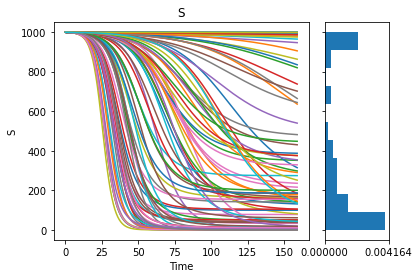

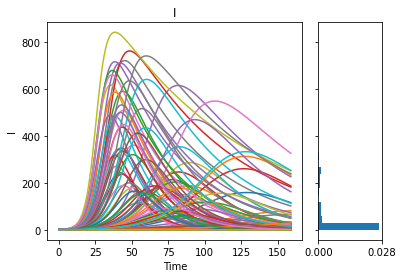

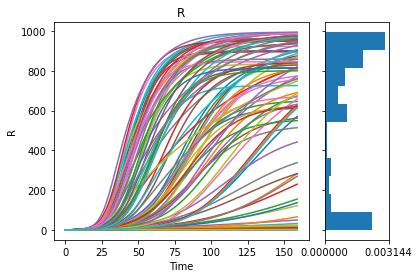

In [11]:
from ema_workbench.analysis import plotting, plotting_util

for outcome in outcomes.keys():
    plotting.lines(experiments, outcomes, outcomes_to_show=outcome, 
                   density=plotting_util.Density.HIST)
plt.show()

A key element in exploratory modeling is to try to understand how points in the uncertainty space map to outcomes or types of outcomes. Since in this example, we only have 2 uncertain parameters, basic visual inspection can already give a fair bit of insight. Let's try to answer the following question: how do $\gamma$ and $\beta$ affect the severity and timing of the outbreak? To answer this we need to do the following:
1. get the maximum value over time for $I$ for each scenario (use np.max)
2. Establish the point in time of this maximum (use np.argmax)
3. visualize how 1 and 2 are affected by $\beta$ and $\gamma$ **jointly** (use scatter plots with max I, and the point in time as color)
4. How are timing and the maximum related to each other?


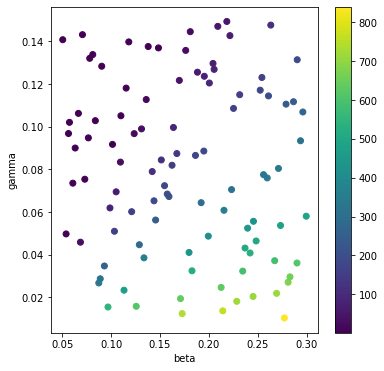

In [12]:
I = outcomes['I']
maxI = np.max(I, axis=1)

fig, ax = plt.subplots(figsize=(6,6))

sc = ax.scatter(experiments.beta, experiments.gamma, c=maxI)
plt.colorbar(sc)
ax.set_xlabel('beta')
ax.set_ylabel('gamma')
plt.show()

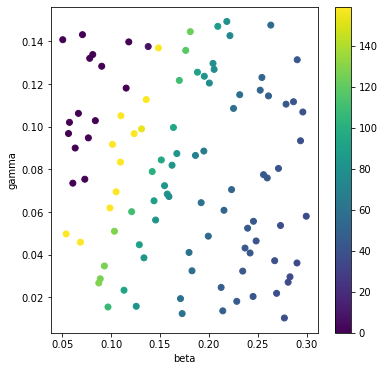

In [13]:
I = outcomes['I']
timing = np.argmax(I, axis=1)

fig, ax = plt.subplots(figsize=(6,6))

sc = ax.scatter(experiments.beta, experiments.gamma, c=timing)
plt.colorbar(sc)
ax.set_xlabel('beta')
ax.set_ylabel('gamma')
plt.show()

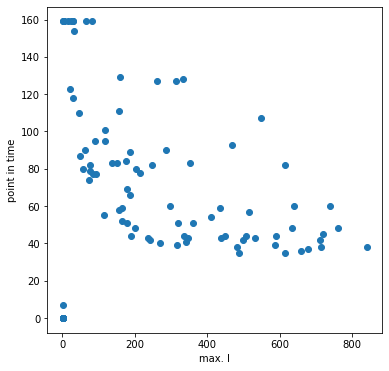

In [14]:
fig, ax = plt.subplots(figsize=(6,6))

sc = ax.scatter(maxI, timing)
ax.set_xlabel('max. I')
ax.set_ylabel('point in time')
plt.show()